<a href="https://colab.research.google.com/github/AdamHsaine/INF8225---Projet-Hiver-25/blob/main/%20INF8225---Projet-Hiver-25/INF8225_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
import numpy as np
import re
!pip install emoji
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, f1_score

# Transformers (pour AraBERT)
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup
)
#Import AdamW from torch.optim
from torch.optim import AdamW
!pip install arabert
# Bibliothèque spécifique pour AraBERT
from arabert.preprocess import ArabertPreprocessor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 11.1 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=2027ad6678a3931d5ee6acd61e1d3c58eab6a418cbb92613762a1562a2340228
  Stored in directory: /root/.cache/pip/wheels/94/08/b4/78657b1541bb704b088317b52429ee4016d9888fe47dbb130f
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.14.1
    Uninstalling emoji-2.14.1:
      Successfully uninstalled emoji-2.14.1


In [3]:
def preprocess_arabic_text(text):

    # Vérification du type de données
    if not isinstance(text, str):
        return ""

    # Normalisation des caractères arabes
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    # Suppression des URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)

    # Suppression des mentions et hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Suppression de la ponctuation non arabe et des caractères spéciaux
    text = re.sub(r'[^\u0600-\u06FF\s]', ' ', text)

    # Suppression des caractères répétés
    text = re.sub(r'(.)\1+', r'\1\1', text)

    # Suppression des espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [4]:
def preprocess_with_arabert(texts, arabert_preprocessor):

    processed_texts = []
    for text in tqdm(texts, desc="Prétraitement AraBERT"):
        # Prétraitement de base
        text = preprocess_arabic_text(text)
        # Prétraitement spécifique AraBERT
        text = arabert_preprocessor.preprocess(text)
        processed_texts.append(text)
    return processed_texts

In [5]:
def load_and_split_data(csv_path, test_size=0.2, val_size=0.1, random_state=42):

    print(f"Chargement des données depuis {csv_path}...")

    # Chargement des données
    df = pd.read_csv(csv_path, sep=',', quotechar='"')

    # Suppression des lignes avec des valeurs manquantes
    df.dropna(subset=['text', 'Classes'], inplace=True)

    # Conversion des classes en valeurs numériques
    # Ici on suppose que les classes sont déjà codées comme -1, 0, 1
    class_mapping = {-1: 0, 0: 1, 1: 2}  # Négatif: 0, Neutre: 1, Positif: 2
    df['Classes'] = df['Classes'].map(class_mapping)

    # Affichage de la distribution des classes
    print("\nDistribution des classes:")
    class_counts = df['Classes'].value_counts().sort_index()
    for class_label, count in class_counts.items():
        print(f"Classe {class_label}: {count} exemples ({count/len(df)*100:.2f}%)")

    # Séparation des ensembles
    # D'abord train vs le reste
    train_df, temp_df = train_test_split(
        df,
        test_size=test_size+val_size,
        random_state=random_state,
        stratify=df['Classes']
    )

    # Puis val vs test
    val_df, test_df = train_test_split(
        temp_df,
        test_size=test_size/(test_size+val_size),
        random_state=random_state,
        stratify=temp_df['Classes']
    )

    print(f"\nEnsemble d'entraînement: {len(train_df)} exemples")
    print(f"Ensemble de validation: {len(val_df)} exemples")
    print(f"Ensemble de test: {len(test_df)} exemples")

    return train_df, val_df, test_df

In [6]:
class ArabicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):

        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


def create_data_loaders(train_df, val_df, test_df, tokenizer, arabert_preprocessor, batch_size=16, max_len=128):

    # Prétraitement des textes avec AraBERT
    print("Prétraitement des textes d'entraînement...")
    train_texts = preprocess_with_arabert(train_df['text'].tolist(), arabert_preprocessor)

    print("Prétraitement des textes de validation...")
    val_texts = preprocess_with_arabert(val_df['text'].tolist(), arabert_preprocessor)

    print("Prétraitement des textes de test...")
    test_texts = preprocess_with_arabert(test_df['text'].tolist(), arabert_preprocessor)

    # Création des datasets
    train_dataset = ArabicDataset(
        texts=train_texts,
        labels=train_df['Classes'].tolist(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    val_dataset = ArabicDataset(
        texts=val_texts,
        labels=val_df['Classes'].tolist(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    test_dataset = ArabicDataset(
        texts=test_texts,
        labels=test_df['Classes'].tolist(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    # Création des dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    return train_loader, val_loader, test_loader

In [7]:
class ArabicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):

        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


def create_data_loaders(train_df, val_df, test_df, tokenizer, arabert_preprocessor, batch_size=16, max_len=128):

    # Prétraitement des textes avec AraBERT
    print("Prétraitement des textes d'entraînement...")
    train_texts = preprocess_with_arabert(train_df['text'].tolist(), arabert_preprocessor)

    print("Prétraitement des textes de validation...")
    val_texts = preprocess_with_arabert(val_df['text'].tolist(), arabert_preprocessor)

    print("Prétraitement des textes de test...")
    test_texts = preprocess_with_arabert(test_df['text'].tolist(), arabert_preprocessor)

    # Création des datasets
    train_dataset = ArabicDataset(
        texts=train_texts,
        labels=train_df['Classes'].tolist(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    val_dataset = ArabicDataset(
        texts=val_texts,
        labels=val_df['Classes'].tolist(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    test_dataset = ArabicDataset(
        texts=test_texts,
        labels=test_df['Classes'].tolist(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    # Création des dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    return train_loader, val_loader, test_loader

In [8]:
def train_model(model, train_loader, val_loader, device, num_epochs=3, learning_rate=2e-5):

    # Optimiseur et scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Pour suivre les meilleures performances
    best_val_f1 = 0
    best_model_state = None

    # Historique d'entraînement
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }

    # Boucle d'entraînement
    print(f"\nDébut de l'entraînement sur {device}...")
    for epoch in range(num_epochs):
        print(f"\nÉpoque {epoch+1}/{num_epochs}")

        # Mode entraînement
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []

        # Boucle sur les batchs d'entraînement
        progress_bar = tqdm(train_loader, desc=f"Entraînement Époque {epoch+1}")
        for batch in progress_bar:
            # Préparation des données
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Réinitialisation des gradients
            model.zero_grad()

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Mise à jour des poids
            optimizer.step()
            scheduler.step()

            # Collecte des statistiques
            train_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            train_preds.extend(preds.cpu().tolist())
            train_labels.extend(labels.cpu().tolist())

            # Mise à jour de la barre de progression
            progress_bar.set_postfix({
                'loss': loss.item()
            })

        # Calcul des métriques d'entraînement
        train_loss = train_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        # Mode évaluation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []

        # Boucle sur les batchs de validation
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                # Préparation des données
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                logits = outputs.logits

                # Collecte des statistiques
                val_loss += loss.item()
                _, preds = torch.max(logits, dim=1)
                val_preds.extend(preds.cpu().tolist())
                val_labels.extend(labels.cpu().tolist())

        # Calcul des métriques de validation
        val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        # Mise à jour de l'historique
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Affichage des métriques
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # Sauvegarde du meilleur modèle
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
            print(f"Nouveau meilleur modèle sauvegardé avec F1 score: {best_val_f1:.4f}")

    # Restauration du meilleur modèle
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Restauration du meilleur modèle avec F1 score: {best_val_f1:.4f}")

    # Tracer les courbes d'apprentissage
    plot_training_history(history)

    return model, history


def plot_training_history(history):

    # Création du plot
    plt.figure(figsize=(12, 5))

    # Plot de la perte
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Entraînement')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Évolution de la perte')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()

    # Plot de la précision
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Entraînement (Acc)')
    plt.plot(history['val_acc'], label='Validation (Acc)')
    plt.plot(history['val_f1'], label='Validation (F1)')
    plt.title('Évolution des métriques')
    plt.xlabel('Époque')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def evaluate_model(model, data_loader, device, class_names=None):

    if class_names is None:
        class_names = ['Négatif', 'Neutre', 'Positif']

    # Passage en mode évaluation
    model.eval()

    # Collecte des prédictions
    predictions = []
    true_labels = []

    # Boucle sur les batchs
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Évaluation"):
            # Préparation des données
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            # Collecte des prédictions
            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    # Calcul des métriques
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Affichage des résultats
    print("\n--- Résultats de l'évaluation ---")
    print(f"Nombre d'exemples: {len(true_labels)}")
    print(f"Précision globale: {accuracy:.4f}")
    print(f"Score F1 (pondéré): {f1:.4f}")

    # Rapport de classification détaillé
    print("\nRapport de classification:")
    print(classification_report(true_labels, predictions, target_names=class_names))

    # Matrice de confusion
    conf_matrix = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title('Matrice de confusion')
    plt.tight_layout()
    plt.show()

    return predictions, true_labels


def analyze_errors(texts, true_labels, predictions, class_names=None):

    if class_names is None:
        class_names = ['Négatif', 'Neutre', 'Positif']

    # Trouver les indices des erreurs
    error_indices = [i for i, (y, y_pred) in enumerate(zip(true_labels, predictions)) if y != y_pred]

    # Afficher quelques exemples d'erreurs
    print(f"\n--- Analyse de {min(10, len(error_indices))} erreurs sur {len(error_indices)} au total ---")

    for i, idx in enumerate(error_indices[:10]):
        text = texts[idx]
        true_label = true_labels[idx]
        pred_label = predictions[idx]

        print(f"\nErreur {i+1}:")
        print(f"Texte: {text[:100]}...")
        print(f"Classe réelle: {class_names[true_label]} ({true_label})")
        print(f"Prédiction: {class_names[pred_label]} ({pred_label})")
        print("-" * 50)

Utilisation du dispositif: cpu
Chargement du modèle aubmindlab/bert-base-arabertv2...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


100%|██████████| 241M/241M [04:19<00:00, 930kiB/s]


[2025-04-26 00:56:39,996 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


Chargement des données depuis /content/drive/MyDrive/INF8225 Projets 2025/Data SA/Data_V2/Data_X - كوفيد00.csv...

Distribution des classes:
Classe 0: 801 exemples (31.49%)
Classe 1: 929 exemples (36.52%)
Classe 2: 814 exemples (32.00%)

Ensemble d'entraînement: 1780 exemples
Ensemble de validation: 254 exemples
Ensemble de test: 510 exemples
Prétraitement des textes d'entraînement...


Prétraitement AraBERT:   0%|          | 0/1780 [00:00<?, ?it/s]

Prétraitement des textes de validation...


Prétraitement AraBERT:   0%|          | 0/254 [00:00<?, ?it/s]

Prétraitement des textes de test...


Prétraitement AraBERT:   0%|          | 0/510 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Début de l'entraînement sur cpu...

Époque 1/3


Entraînement Époque 1:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.9036 | Train Acc: 0.5764 | Train F1: 0.5763
Val Loss: 0.7527 | Val Acc: 0.7008 | Val F1: 0.6994
Nouveau meilleur modèle sauvegardé avec F1 score: 0.6994

Époque 2/3


Entraînement Époque 2:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.6786 | Train Acc: 0.7275 | Train F1: 0.7276
Val Loss: 0.7175 | Val Acc: 0.6929 | Val F1: 0.6907

Époque 3/3


Entraînement Époque 3:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed3c97359e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed3c97359e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.5550 | Train Acc: 0.7904 | Train F1: 0.7905
Val Loss: 0.6987 | Val Acc: 0.7165 | Val F1: 0.7157
Nouveau meilleur modèle sauvegardé avec F1 score: 0.7157
Restauration du meilleur modèle avec F1 score: 0.7157


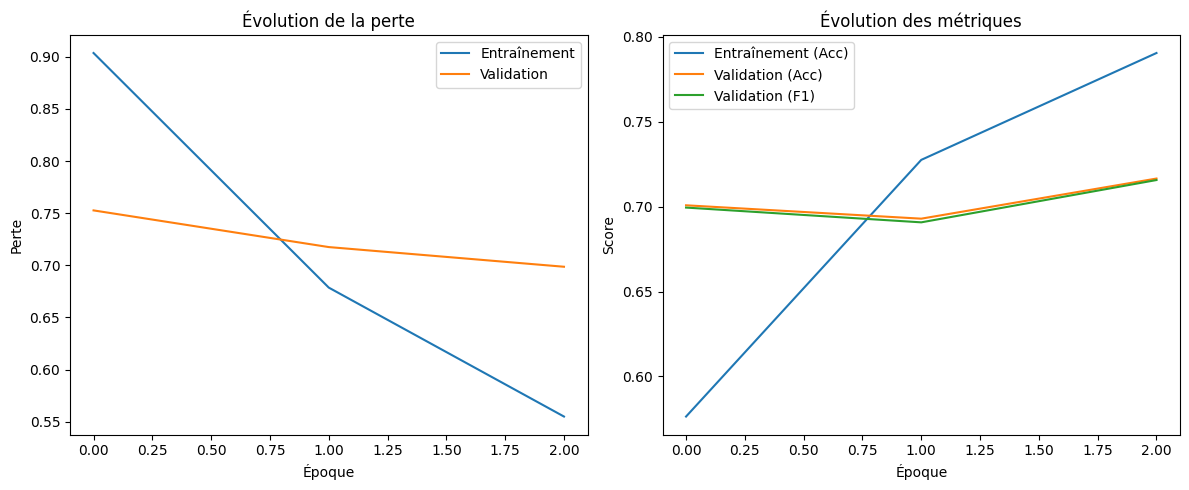


Évaluation sur l'ensemble de test:


Évaluation:   0%|          | 0/32 [00:00<?, ?it/s]


--- Résultats de l'évaluation ---
Nombre d'exemples: 510
Précision globale: 0.6569
Score F1 (pondéré): 0.6561

Rapport de classification:
              precision    recall  f1-score   support

     Négatif       0.68      0.60      0.64       161
      Neutre       0.61      0.64      0.63       186
     Positif       0.69      0.74      0.71       163

    accuracy                           0.66       510
   macro avg       0.66      0.66      0.66       510
weighted avg       0.66      0.66      0.66       510



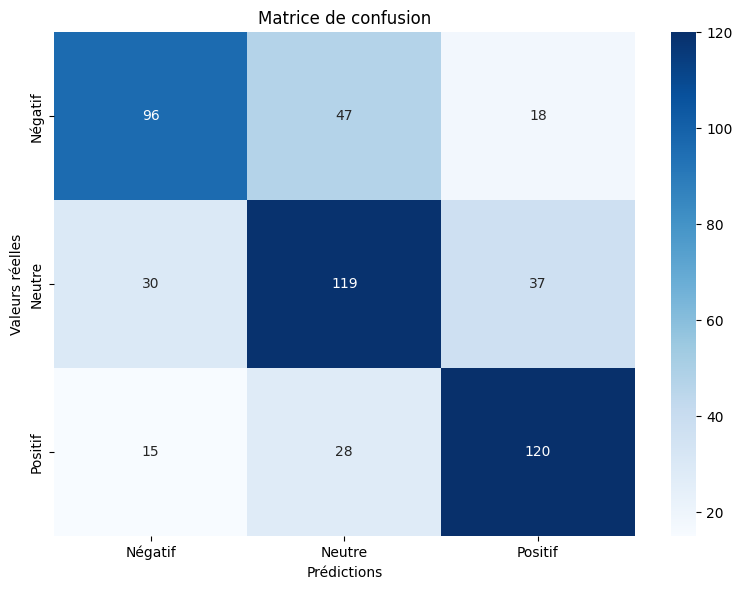


--- Analyse de 10 erreurs sur 175 au total ---

Erreur 1:
Texte: "أنا عانيت من كوني وحيداً، لكن في سبيل الحفاظ على سري، تغلبت على الوحدة، واليوم أنا لا أعرف مجداً أع...
Classe réelle: Neutre (1)
Prédiction: Positif (2)
--------------------------------------------------

Erreur 2:
Texte: إشاعات وافتراءات وعن المظاهرات في الأحواز ، أعمل نفسك ميت . 
النفاق عقالكم https://t.co/ILEaEZSAJs...
Classe réelle: Neutre (1)
Prédiction: Négatif (0)
--------------------------------------------------

Erreur 3:
Texte: #اقتحام_8_ذوالحجة 
#يوم_عرفة 
#عيد_الأضحى_المبارك 
#عيد_الاضحى 
#يوم_الترويه
و في يوم التروية
اللهم ...
Classe réelle: Neutre (1)
Prédiction: Positif (2)
--------------------------------------------------

Erreur 4:
Texte: @ChakibLahlimi وانا..كذلك...قيدوا..حسابي...على

الفايس..بوك......
Classe réelle: Négatif (0)
Prédiction: Neutre (1)
--------------------------------------------------

Erreur 5:
Texte: @zelenyovadil راه عليه الصليب ديال النصارى ... 🙊🙉🙈...
Classe réelle: Neutre (1)
Pr

In [10]:
def main():

    config = {
        'model_name': "aubmindlab/bert-base-arabertv2",
        'data_path': "/content/drive/MyDrive/INF8225 Projets 2025/Data SA/Data_V2/Data_X - كوفيد00.csv",  # chemin des données
        'max_len': 128,
        'batch_size': 16,
        'num_epochs': 3,
        'learning_rate': 2e-5,
        'random_state': 42,
        'num_classes': 3,
        'class_names': ['Négatif', 'Neutre', 'Positif'],
        'output_dir': "./models/arabert_sentiment",
    }

    # Création du répertoire de sortie
    os.makedirs(config['output_dir'], exist_ok=True)

    # Vérification de la disponibilité du GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Utilisation du dispositif: {device}")

    # Chargement du tokenizer et du préprocesseur
    print(f"Chargement du modèle {config['model_name']}...")
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
    arabert_preprocessor = ArabertPreprocessor(model_name=config['model_name'])

    # Chargement et division des données
    train_df, val_df, test_df = load_and_split_data(config['data_path'], random_state=config['random_state'])

    # Création des data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        train_df,
        val_df,
        test_df,
        tokenizer,
        arabert_preprocessor,
        batch_size=config['batch_size'],
        max_len=config['max_len']
    )

    # Initialisation du modèle
    model = AutoModelForSequenceClassification.from_pretrained(
        config['model_name'],
        num_labels=config['num_classes']
    )
    model = model.to(device)

    # Entraînement du modèle
    model, history = train_model(
        model,
        train_loader,
        val_loader,
        device,
        num_epochs=config['num_epochs'],
        learning_rate=config['learning_rate']
    )

    # Évaluation sur l'ensemble de test
    print("\nÉvaluation sur l'ensemble de test:")
    predictions, true_labels = evaluate_model(
        model,
        test_loader,
        device,
        class_names=config['class_names']
    )

    # Analyse des erreurs
    # Pour cela, nous avons besoin des textes originaux de l'ensemble de test
    test_texts = test_df['text'].tolist()
    analyze_errors(test_texts, true_labels, predictions, class_names=config['class_names'])

    # Sauvegarde du modèle et des configurations
    print(f"\nSauvegarde du modèle dans {config['output_dir']}...")
    model.save_pretrained(config['output_dir'])
    tokenizer.save_pretrained(config['output_dir'])

    # Sauvegarde de la configuration
    with open(os.path.join(config['output_dir'], 'config.txt'), 'w') as f:
        for key, value in config.items():
            f.write(f"{key}: {value}\n")

    print("Modèle sauvegardé avec succès!")

    return model, tokenizer, history


if __name__ == "__main__":
    main()

Chargement des données depuis /content/drive/MyDrive/INF8225 Projets 2025/Data SA/Data_V2/Data_X - كوفيد00.csv

Distribution des classes:
Classe 0: 801 exemples (31.49%)
Classe 1: 929 exemples (36.52%)
Classe 2: 814 exemples (32.00%)
Ensemble d'entraînement: 2035 exemples
Ensemble de test: 509 exemples

MODÈLE: TF-IDF + SVM
Transformation des textes avec TfidfVectorizer...
Entraînement du modèle TF-IDF + SVM...
Temps d'entraînement: 0.10 secondes

--- Résultats de l'évaluation ---
Modèle: TF-IDF + SVM
Précision: 0.5599
Score F1 (pondéré): 0.5596

Rapport de classification:
              precision    recall  f1-score   support

     Négatif       0.53      0.61      0.57       160
      Neutre       0.54      0.49      0.52       186
     Positif       0.62      0.58      0.60       163

    accuracy                           0.56       509
   macro avg       0.56      0.56      0.56       509
weighted avg       0.56      0.56      0.56       509



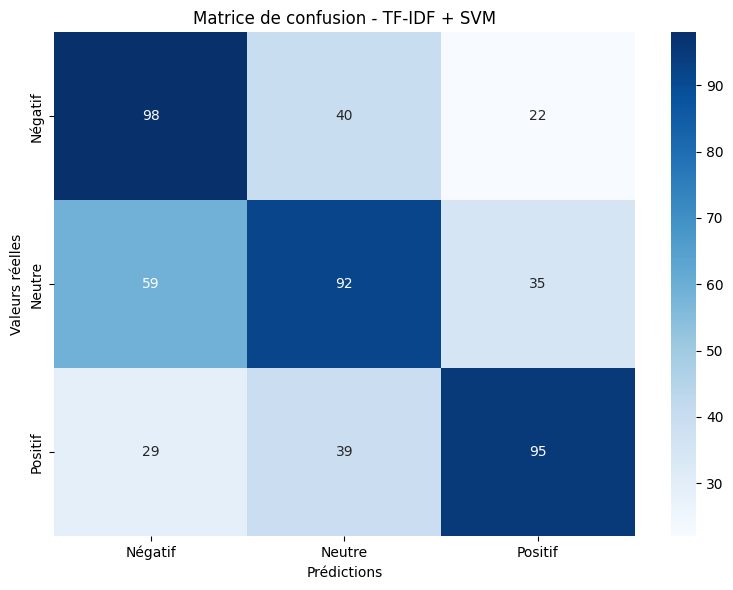


MODÈLE: TF-IDF + Random Forest
Transformation des textes avec TfidfVectorizer...
Entraînement du modèle TF-IDF + Random Forest...
Temps d'entraînement: 3.32 secondes

--- Résultats de l'évaluation ---
Modèle: TF-IDF + Random Forest
Précision: 0.5442
Score F1 (pondéré): 0.5423

Rapport de classification:
              precision    recall  f1-score   support

     Négatif       0.52      0.41      0.46       160
      Neutre       0.48      0.69      0.57       186
     Positif       0.72      0.51      0.60       163

    accuracy                           0.54       509
   macro avg       0.57      0.54      0.54       509
weighted avg       0.57      0.54      0.54       509



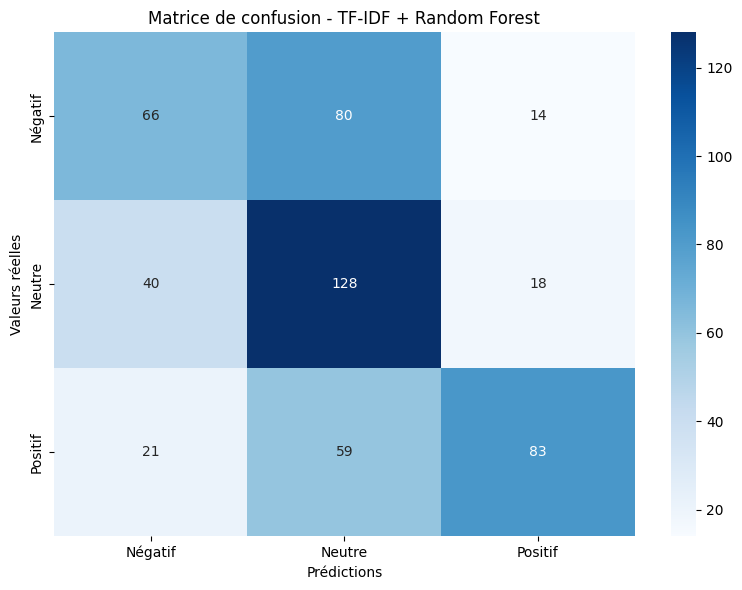

[2025-04-26 01:58:41,256 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.



MODÈLE: AraBERT
Chargement des données depuis /content/drive/MyDrive/INF8225 Projets 2025/Data SA/Data_V2/Data_X - كوفيد00.csv

Distribution des classes:
Classe 0: 801 exemples (31.49%)
Classe 1: 929 exemples (36.52%)
Classe 2: 814 exemples (32.00%)
Application du prétraitement spécifique...
Ensemble d'entraînement: 2035 exemples
Ensemble de test: 509 exemples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Utilisation du dispositif: cpu

Époque 1/3


Entraînement Époque 1:   0%|          | 0/128 [00:00<?, ?it/s]

Perte moyenne de l'époque: 0.8745

Époque 2/3


Entraînement Époque 2:   0%|          | 0/128 [00:00<?, ?it/s]

Perte moyenne de l'époque: 0.6625

Époque 3/3


Entraînement Époque 3:   0%|          | 0/128 [00:00<?, ?it/s]

Perte moyenne de l'époque: 0.5493
Temps d'entraînement: 2301.05 secondes


Évaluation:   0%|          | 0/32 [00:00<?, ?it/s]


--- Résultats de l'évaluation ---
Modèle: AraBERT
Précision: 0.6935
Score F1 (pondéré): 0.6942

Rapport de classification:
              precision    recall  f1-score   support

     Négatif       0.70      0.69      0.70       160
      Neutre       0.64      0.68      0.66       186
     Positif       0.75      0.71      0.73       163

    accuracy                           0.69       509
   macro avg       0.70      0.69      0.70       509
weighted avg       0.70      0.69      0.69       509



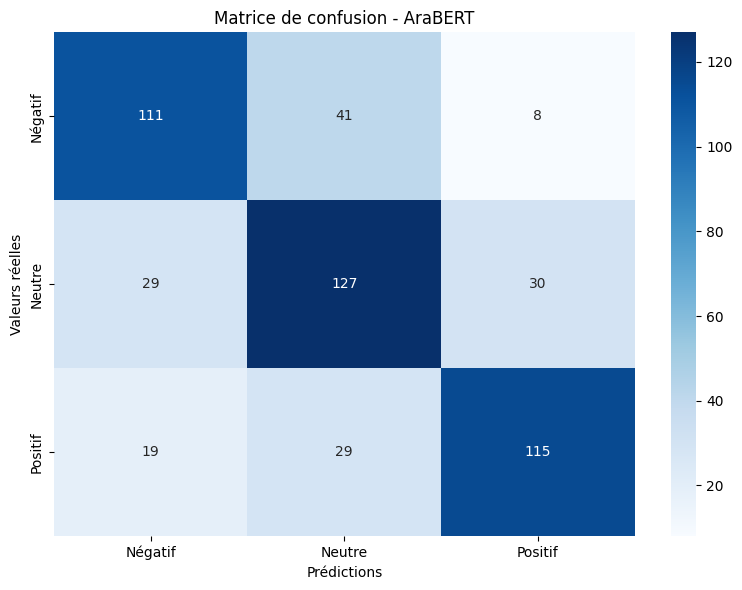


MODÈLE: MARBERT


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Utilisation du dispositif: cpu

Époque 1/3


Entraînement Époque 1:   0%|          | 0/128 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Perte moyenne de l'époque: 0.8671

Époque 2/3


Entraînement Époque 2:   0%|          | 0/128 [00:00<?, ?it/s]

Perte moyenne de l'époque: 0.5615

Époque 3/3


Entraînement Époque 3:   0%|          | 0/128 [00:00<?, ?it/s]

Perte moyenne de l'époque: 0.3366
Temps d'entraînement: 2389.21 secondes


Évaluation:   0%|          | 0/32 [00:00<?, ?it/s]


--- Résultats de l'évaluation ---
Modèle: MARBERT
Précision: 0.7171
Score F1 (pondéré): 0.7169

Rapport de classification:
              precision    recall  f1-score   support

     Négatif       0.71      0.74      0.72       160
      Neutre       0.68      0.66      0.67       186
     Positif       0.77      0.76      0.77       163

    accuracy                           0.72       509
   macro avg       0.72      0.72      0.72       509
weighted avg       0.72      0.72      0.72       509



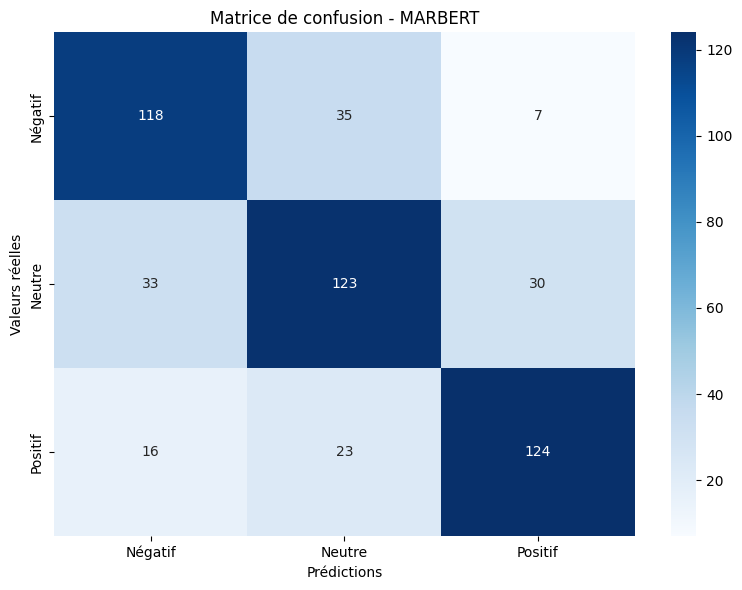


MODÈLE: CamemBERT


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Utilisation du dispositif: cpu

Époque 1/3


Entraînement Époque 1:   0%|          | 0/128 [00:00<?, ?it/s]

Perte moyenne de l'époque: 1.0816

Époque 2/3


Entraînement Époque 2:   0%|          | 0/128 [00:00<?, ?it/s]

Perte moyenne de l'époque: 1.0651

Époque 3/3


Entraînement Époque 3:   0%|          | 0/128 [00:00<?, ?it/s]

Perte moyenne de l'époque: 1.0595
Temps d'entraînement: 2158.16 secondes


Évaluation:   0%|          | 0/32 [00:00<?, ?it/s]


--- Résultats de l'évaluation ---
Modèle: CamemBERT
Précision: 0.4204
Score F1 (pondéré): 0.4005

Rapport de classification:
              precision    recall  f1-score   support

     Négatif       0.40      0.59      0.48       160
      Neutre       0.46      0.49      0.47       186
     Positif       0.38      0.18      0.24       163

    accuracy                           0.42       509
   macro avg       0.41      0.42      0.40       509
weighted avg       0.42      0.42      0.40       509



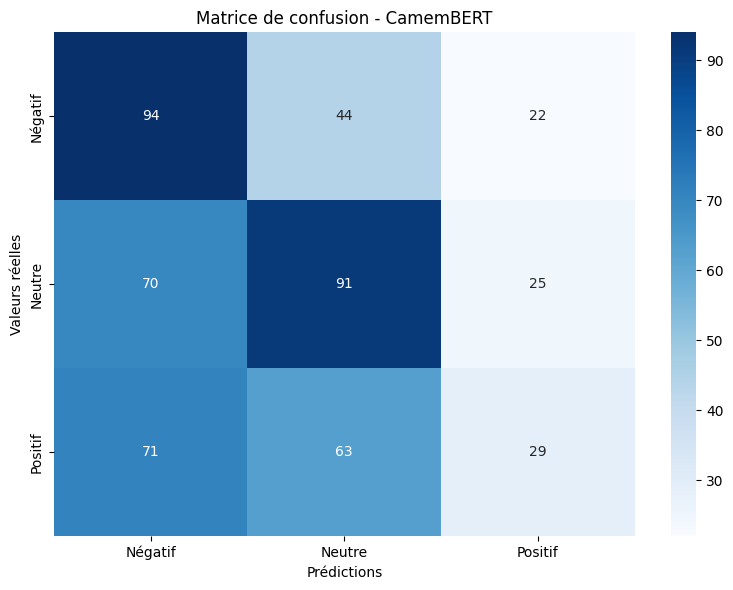


COMPARAISON FINALE

Tableau de comparaison des modèles:
| Modèle | Accuracy | F1 Weighted | Precision Weighted | Recall Weighted | Temps d'entraînement |
| --- | --- | --- | --- | --- | --- |
| TF-IDF + SVM | 0.5599 | 0.5596 | 0.5624 | 0.5599 | 0.1s |
| TF-IDF + Random Forest | 0.5442 | 0.5423 | 0.5697 | 0.5442 | 3.3s |
| AraBERT | 0.6935 | 0.6942 | 0.6957 | 0.6935 | 2301.1s |
| MARBERT | 0.7171 | 0.7169 | 0.7171 | 0.7171 | 2389.2s |
| CamemBERT | 0.4204 | 0.4005 | 0.4159 | 0.4204 | 2158.2s |


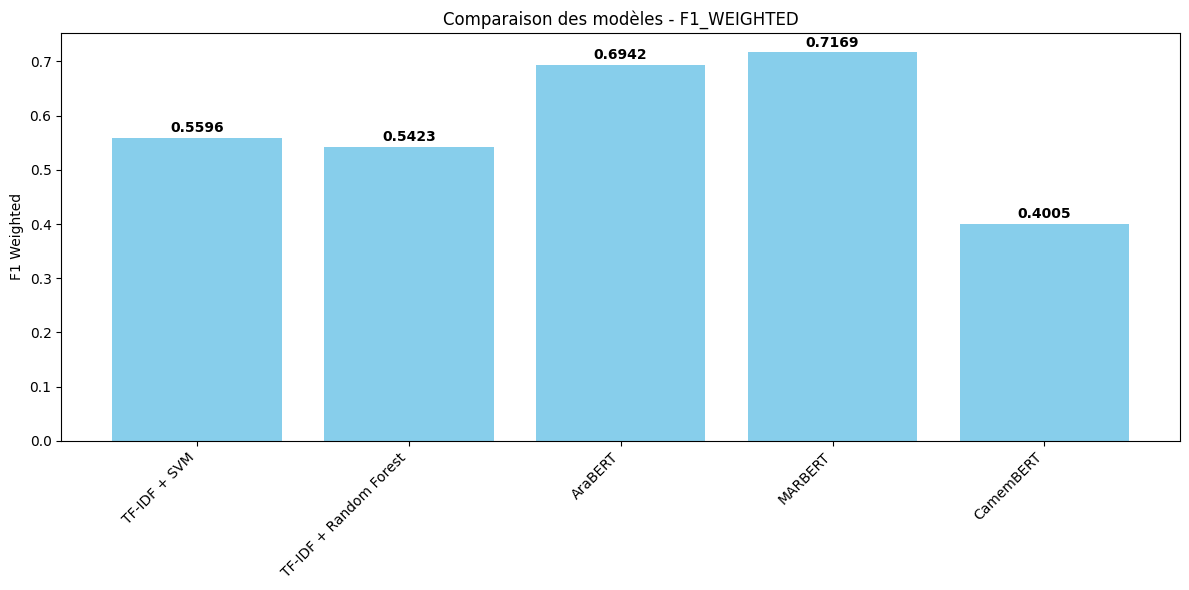

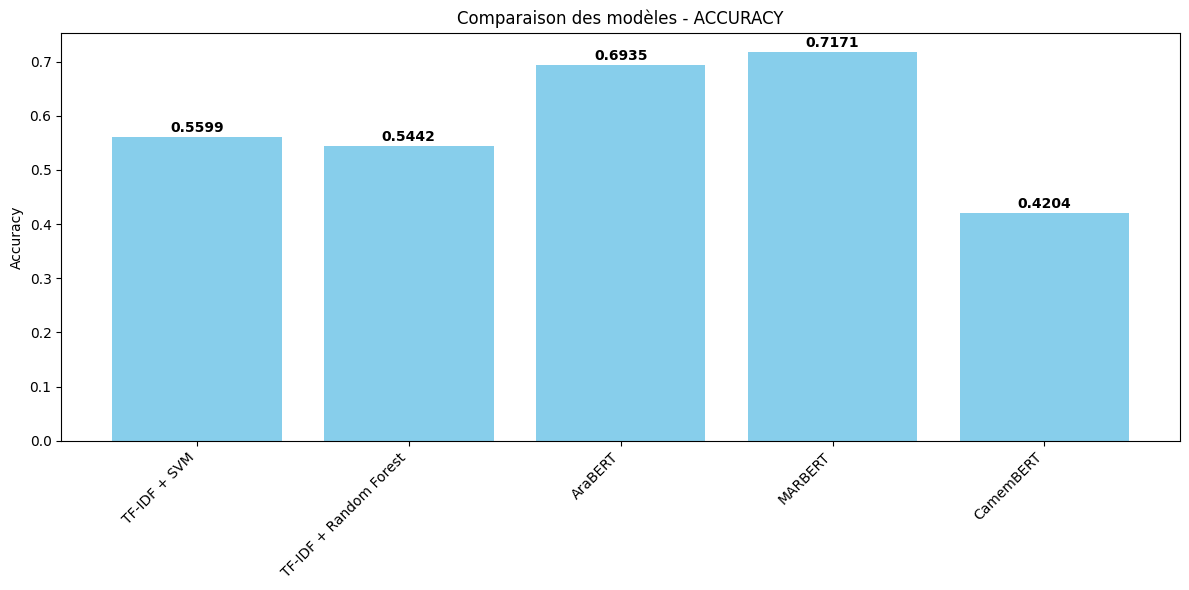

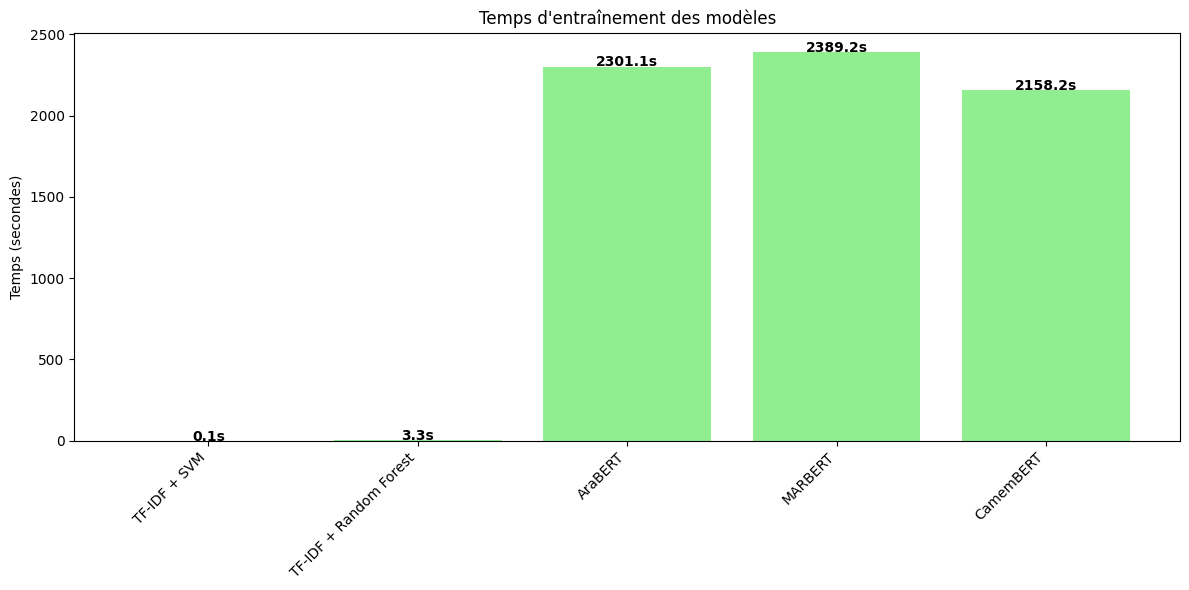

In [14]:
import os
import pandas as pd
import numpy as np
import re
import emoji
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from collections import defaultdict

# PyTorch et bibliothèques de ML
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Transformers pour les modèles basés sur BERT
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    MarianMTModel,
    MarianTokenizer,
    CamembertTokenizer,
    CamembertForSequenceClassification
)

from torch.optim import AdamW

# Bibliothèque pour le prétraitement arabe
from arabert.preprocess import ArabertPreprocessor


class ExperimentTracker:
    """
    Classe pour suivre et comparer les performances de différents modèles.
    """
    def __init__(self, output_dir="./model_comparison"):
        self.results = {}
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def add_result(self, model_name, metrics, train_time, parameters=None):
        """
        Ajoute les résultats d'un modèle à la comparaison.
        """
        self.results[model_name] = {
            "metrics": metrics,
            "train_time": train_time,
            "parameters": parameters or {}
        }

    def save_results(self):
        """
        Sauvegarde les résultats dans un fichier JSON.
        """
        with open(os.path.join(self.output_dir, "comparison_results.json"), "w", encoding="utf-8") as f:
            json.dump(self.results, f, indent=4)

    def plot_comparison(self, metric="f1_weighted"):
        """
        Crée un graphique comparatif des performances des modèles.
        """
        models = list(self.results.keys())
        values = [self.results[model]["metrics"][metric] for model in models]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(models, values, color='skyblue')

        # Ajouter les valeurs sur les barres
        for bar, value in zip(bars, values):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.01,
                f"{value:.4f}",
                ha='center',
                fontweight='bold'
            )

        plt.title(f"Comparaison des modèles - {metric.upper()}")
        plt.ylabel(metric.replace('_', ' ').title())
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, f"comparison_{metric}.png"))
        plt.show()

    def plot_train_times(self):
        """
        Crée un graphique comparatif des temps d'entraînement.
        """
        models = list(self.results.keys())
        times = [self.results[model]["train_time"] for model in models]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(models, times, color='lightgreen')

        # Ajouter les valeurs sur les barres
        for bar, time_val in zip(bars, times):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 1,
                f"{time_val:.1f}s",
                ha='center',
                fontweight='bold'
            )

        plt.title("Temps d'entraînement des modèles")
        plt.ylabel("Temps (secondes)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "comparison_train_times.png"))
        plt.show()

    def generate_comparison_table(self):
        """
        Génère un tableau comparatif au format Markdown.
        """
        metrics = ["accuracy", "f1_weighted", "precision_weighted", "recall_weighted"]

        # En-tête du tableau
        header = "| Modèle | " + " | ".join(metric.replace("_", " ").title() for metric in metrics) + " | Temps d'entraînement |"
        separator = "| --- | " + " | ".join(["---"] * (len(metrics) + 1)) + " |"

        rows = []
        for model, data in self.results.items():
            metrics_values = [f"{data['metrics'].get(metric, 'N/A'):.4f}" for metric in metrics]
            train_time = f"{data['train_time']:.1f}s"
            row = f"| {model} | " + " | ".join(metrics_values) + f" | {train_time} |"
            rows.append(row)

        table = "\n".join([header, separator] + rows)

        with open(os.path.join(self.output_dir, "comparison_table.md"), "w", encoding="utf-8") as f:
            f.write(table)

        return table


def preprocess_arabic_text(text, basic_only=False):

    if not isinstance(text, str):
        return ""

    # Normalisation des caractères arabes
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    # Suppression des URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)

    if not basic_only:
        # Suppression des mentions et hashtags
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)

        # Suppression de la ponctuation non arabe et des caractères spéciaux
        text = re.sub(r'[^\u0600-\u06FF\s]', ' ', text)

    # Suppression des caractères répétés
    text = re.sub(r'(.)\1+', r'\1\1', text)

    # Suppression des espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text


class ArabicDataset(Dataset):

    def __init__(self, texts, labels, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        if self.tokenizer:
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )

            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'text': text,
                'labels': label
            }


def load_and_prepare_data(data_path, test_size=0.2, random_state=42, preprocessor=None):

    print(f"Chargement des données depuis {data_path}")

    # Chargement des données
    df =  pd.read_csv(data_path, sep=',', quotechar='"')

    # Suppression des valeurs manquantes
    df.dropna(subset=['text', 'Classes'], inplace=True)

    # Conversion des classes
    class_mapping = {-1: 0, 0: 1, 1: 2}  # Négatif: 0, Neutre: 1, Positif: 2
    df['Classes'] = df['Classes'].map(class_mapping)

    # Affichage de la distribution des classes
    print("\nDistribution des classes:")
    class_counts = df['Classes'].value_counts().sort_index()
    for class_label, count in class_counts.items():
        print(f"Classe {class_label}: {count} exemples ({count/len(df)*100:.2f}%)")

    # Prétraitement de base pour tous les textes
    df['text_preprocessed'] = df['text'].apply(lambda x: preprocess_arabic_text(x, basic_only=True))

    # Prétraitement spécifique si preprocessor est fourni
    if preprocessor:
        print("Application du prétraitement spécifique...")
        df['text_preprocessed'] = df['text_preprocessed'].apply(lambda x: preprocessor.preprocess(x))

    # Séparation en ensembles d'entraînement et de test
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=random_state,
        stratify=df['Classes']
    )

    print(f"Ensemble d'entraînement: {len(train_df)} exemples")
    print(f"Ensemble de test: {len(test_df)} exemples")

    return train_df, test_df


def train_traditional_model(model, vectorizer, X_train, y_train, model_name):

    start_time = time.time()

    # Transformation des textes en vecteurs
    print(f"Transformation des textes avec {vectorizer.__class__.__name__}...")
    X_train_vec = vectorizer.fit_transform(X_train)

    # Entraînement du modèle
    print(f"Entraînement du modèle {model_name}...")
    model.fit(X_train_vec, y_train)

    train_time = time.time() - start_time
    print(f"Temps d'entraînement: {train_time:.2f} secondes")

    return model, vectorizer, train_time


def evaluate_traditional_model(model, vectorizer, X_test, y_test, model_name):

    # Transformation des textes de test
    X_test_vec = vectorizer.transform(X_test)

    # Prédictions
    y_pred = model.predict(X_test_vec)

    # Calcul des métriques
    metrics = calculate_metrics(y_test, y_pred)

    # Affichage des résultats
    print("\n--- Résultats de l'évaluation ---")
    print(f"Modèle: {model_name}")
    print(f"Précision: {metrics['accuracy']:.4f}")
    print(f"Score F1 (pondéré): {metrics['f1_weighted']:.4f}")

    # Rapport de classification
    print("\nRapport de classification:")
    print(classification_report(y_test, y_pred, target_names=['Négatif', 'Neutre', 'Positif']))

    # Matrice de confusion
    plot_confusion_matrix(y_test, y_pred, ['Négatif', 'Neutre', 'Positif'], model_name)

    return metrics


def train_and_evaluate_transformer_model(model, tokenizer, train_df, test_df, model_name,
                                        batch_size=16, num_epochs=3, learning_rate=2e-5, max_len=128):

    # Préparation des datasets
    train_dataset = ArabicDataset(
        texts=train_df['text_preprocessed'].tolist(),
        labels=train_df['Classes'].tolist(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    test_dataset = ArabicDataset(
        texts=test_df['text_preprocessed'].tolist(),
        labels=test_df['Classes'].tolist(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    # Création des dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0  # Évite les problèmes de multiprocessing
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    # Détection du GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Utilisation du dispositif: {device}")

    # Transfert du modèle sur le dispositif
    model = model.to(device)

    # Optimiseur et scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Entraînement
    start_time = time.time()

    model.train()
    for epoch in range(num_epochs):
        print(f"\nÉpoque {epoch+1}/{num_epochs}")

        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Entraînement Époque {epoch+1}")

        for batch in progress_bar:
            # Préparation des données
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Réinitialisation des gradients
            model.zero_grad()

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Mise à jour des poids
            optimizer.step()
            scheduler.step()

            # Collecte des statistiques
            epoch_loss += loss.item()

            # Mise à jour de la barre de progression
            progress_bar.set_postfix({'loss': loss.item()})

        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Perte moyenne de l'époque: {avg_epoch_loss:.4f}")

    train_time = time.time() - start_time
    print(f"Temps d'entraînement: {train_time:.2f} secondes")

    # Évaluation
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Évaluation"):
            # Préparation des données
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            # Collecte des prédictions
            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    # Calcul des métriques
    metrics = calculate_metrics(true_labels, predictions)

    # Affichage des résultats
    print("\n--- Résultats de l'évaluation ---")
    print(f"Modèle: {model_name}")
    print(f"Précision: {metrics['accuracy']:.4f}")
    print(f"Score F1 (pondéré): {metrics['f1_weighted']:.4f}")

    # Rapport de classification
    print("\nRapport de classification:")
    print(classification_report(true_labels, predictions, target_names=['Négatif', 'Neutre', 'Positif']))

    # Matrice de confusion
    plot_confusion_matrix(true_labels, predictions, ['Négatif', 'Neutre', 'Positif'], model_name)

    return model, metrics, train_time


def calculate_metrics(y_true, y_pred):
    """
    Calcule les métriques d'évaluation.
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_micro': f1_score(y_true, y_pred, average='micro')
    }
    return metrics


def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """
    Génère et affiche la matrice de confusion.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title(f'Matrice de confusion - {model_name}')
    plt.tight_layout()
    plt.show()


def compare_models(data_path, output_dir="./model_comparison"):

    # Création du tracker d'expériences
    tracker = ExperimentTracker(output_dir=output_dir)

    # 1. Chargement des données pour les modèles classiques
    train_df, test_df = load_and_prepare_data(data_path)

    # Paramètres communs
    batch_size = 16
    num_epochs = 3
    learning_rate = 2e-5
    max_len = 128

    # 2. TF-IDF + SVM
    print("\n" + "="*50)
    print("MODÈLE: TF-IDF + SVM")
    print("="*50)

    vectorizer = TfidfVectorizer(max_features=10000)
    svm_model = LinearSVC()

    model, vectorizer, train_time = train_traditional_model(
        svm_model,
        vectorizer,
        train_df['text_preprocessed'],
        train_df['Classes'],
        "TF-IDF + SVM"
    )

    metrics = evaluate_traditional_model(
        model,
        vectorizer,
        test_df['text_preprocessed'],
        test_df['Classes'],
        "TF-IDF + SVM"
    )

    tracker.add_result(
        "TF-IDF + SVM",
        metrics,
        train_time,
        {"max_features": 10000}
    )

    # 3. TF-IDF + Random Forest
    print("\n" + "="*50)
    print("MODÈLE: TF-IDF + Random Forest")
    print("="*50)

    vectorizer = TfidfVectorizer(max_features=10000)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    model, vectorizer, train_time = train_traditional_model(
        rf_model,
        vectorizer,
        train_df['text_preprocessed'],
        train_df['Classes'],
        "TF-IDF + Random Forest"
    )

    metrics = evaluate_traditional_model(
        model,
        vectorizer,
        test_df['text_preprocessed'],
        test_df['Classes'],
        "TF-IDF + Random Forest"
    )

    tracker.add_result(
        "TF-IDF + Random Forest",
        metrics,
        train_time,
        {"n_estimators": 100}
    )

    # 4. AraBERT
    print("\n" + "="*50)
    print("MODÈLE: AraBERT")
    print("="*50)

    # Chargement des données avec prétraitement AraBERT
    arabert_preprocessor = ArabertPreprocessor(model_name="aubmindlab/bert-base-arabertv2")
    arabert_train_df, arabert_test_df = load_and_prepare_data(
        data_path,
        preprocessor=arabert_preprocessor
    )

    # Chargement du modèle et du tokenizer
    arabert_tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
    arabert_model = AutoModelForSequenceClassification.from_pretrained(
        "aubmindlab/bert-base-arabertv2",
        num_labels=3
    )

    # Entraînement et évaluation
    model, metrics, train_time = train_and_evaluate_transformer_model(
        arabert_model,
        arabert_tokenizer,
        arabert_train_df,
        arabert_test_df,
        "AraBERT",
        batch_size=batch_size,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        max_len=max_len
    )

    tracker.add_result(
        "AraBERT",
        metrics,
        train_time,
        {
            "batch_size": batch_size,
            "num_epochs": num_epochs,
            "learning_rate": learning_rate,
            "max_len": max_len
        }
    )

    # 5. MARBERT (spécialisé pour l'arabe des médias sociaux)
    try:
        print("\n" + "="*50)
        print("MODÈLE: MARBERT")
        print("="*50)

        # Chargement du modèle et du tokenizer
        marbert_tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")
        marbert_model = AutoModelForSequenceClassification.from_pretrained(
            "UBC-NLP/MARBERT",
            num_labels=3
        )

        # Entraînement et évaluation
        model, metrics, train_time = train_and_evaluate_transformer_model(
            marbert_model,
            marbert_tokenizer,
            train_df,  # Pas besoin de prétraitement spécial
            test_df,
            "MARBERT",
            batch_size=batch_size,
            num_epochs=num_epochs,
            learning_rate=learning_rate,
            max_len=max_len
        )

        tracker.add_result(
            "MARBERT",
            metrics,
            train_time,
            {
                "batch_size": batch_size,
                "num_epochs": num_epochs,
                "learning_rate": learning_rate,
                "max_len": max_len
            }
        )
    except Exception as e:
        print(f"Erreur lors du chargement de MARBERT: {e}")

    # 6. CamemBERT (pour comparer avec un modèle français)
    try:
        print("\n" + "="*50)
        print("MODÈLE: CamemBERT")
        print("="*50)

        # Chargement du modèle et du tokenizer
        camembert_tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
        camembert_model = CamembertForSequenceClassification.from_pretrained(
            "camembert-base",
            num_labels=3
        )

        # Entraînement et évaluation
        model, metrics, train_time = train_and_evaluate_transformer_model(
            camembert_model,
            camembert_tokenizer,
            train_df,
            test_df,
            "CamemBERT",
            batch_size=batch_size,
            num_epochs=num_epochs,
            learning_rate=learning_rate,
            max_len=max_len
        )

        tracker.add_result(
            "CamemBERT",
            metrics,
            train_time,
            {
                "batch_size": batch_size,
                "num_epochs": num_epochs,
                "learning_rate": learning_rate,
                "max_len": max_len
            }
        )
    except Exception as e:
        print(f"Erreur lors du chargement de CamemBERT: {e}")

    # Sauvegarde et affichage des résultats
    tracker.save_results()

    print("\n" + "="*50)
    print("COMPARAISON FINALE")
    print("="*50)

    # Afficher le tableau de comparaison
    comparison_table = tracker.generate_comparison_table()
    print("\nTableau de comparaison des modèles:")
    print(comparison_table)

    # Tracer les graphiques
    tracker.plot_comparison(metric="f1_weighted")
    tracker.plot_comparison(metric="accuracy")
    tracker.plot_train_times()

    return tracker


if __name__ == "__main__":
    # Chemin vers vos données
    data_path = "/content/drive/MyDrive/INF8225 Projets 2025/Data SA/Data_V2/Data_X - كوفيد00.csv"  # À remplacer

    # Lancer la comparaison
    tracker = compare_models(data_path)